<a href="https://colab.research.google.com/github/shazzad-hasan/tensorflow-projects/blob/main/tweet_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we will train a model to recognize tweet emotion using the tweet emotion dataset. 

In [2]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 212 kB 61.4 MB/s 


In [5]:
# import required libraries

import tensorflow as tf
import nlp

import numpy as np
import random
import matplotlib.pyplot as plt

%matplotlib inline

### Load and visualize dataset

In [6]:
# load tweet emotion dataset from huggingface nlp module
dataset = nlp.load_dataset("emotion")

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [8]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [7]:
train_data = dataset['train']
valid_data = dataset['validation']
test_data = dataset['test']

In [17]:
# obtain tweets and labels from the data
def get_tweet(data):
  tweets = [x['text'] for x in data] # obtain tweets
  labels = [x['label'] for x in data] # obtain tweets labels
  return tweets, labels

# obtain training tweets and labels 
tweets, labels = get_tweet(train_data)

# let's see first 10 tweets and corresponding labels
for i in range(10):
  print("({}, {})".format(tweets[i], labels[i]))

(i didnt feel humiliated, sadness)
(i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake, sadness)
(im grabbing a minute to post i feel greedy wrong, anger)
(i am ever feeling nostalgic about the fireplace i will know that it is still on the property, love)
(i am feeling grouchy, anger)
(ive been feeling a little burdened lately wasnt sure why that was, sadness)
(ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny, surprise)
(i feel as confused about life as a teenager or as jaded as a year old man, fear)
(i have been with petronas for years i feel that petronas has performed well and made a huge profit, joy)
(i feel romantic too, love)


### Pre-process the dataset

#### Prepare tweets

##### Tokenize the tweets

In [28]:
from tensorflow.keras.preprocessing.text import Tokenizer

# let's tokenize 10,000 most commonly used words
tokenizer = Tokenizer(num_words=1000, oov_token="UNK")
tokenizer.fit_on_texts(tweets)

In [29]:
# lets see the tokinization of a tweet
print("{} ---> {}".format(tweets[0], tokenizer.texts_to_sequences([tweets[0]])))

i didnt feel humiliated ---> [[2, 139, 3, 679]]


##### Padding and Truncating sequences

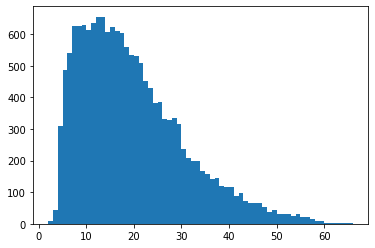

In [30]:
# check length of the tweets
lengths = [len(twt.split(" ")) for twt in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

maxlen = 50

def get_sequences(tokenizer, tweets):
  # tokenize tweets
  sequences = tokenizer.texts_to_sequences(tweets)
  # obtain padded and truncated sequences
  padded_seqs = pad_sequences(sequences, truncating="post", padding="post", maxlen=maxlen)
  return padded_seqs

In [42]:
# obtain padded and truncated training sequences
padded_train_seq = get_sequences(tokenizer, tweets)

print("{}, \n{}".format(tweets[0], padded_train_seq[0]))

i didnt feel humiliated, 
[  2 139   3 679   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0]


#### Prepare labels

In [43]:
classes = set(labels)
print(classes)

{'surprise', 'joy', 'love', 'fear', 'anger', 'sadness'}


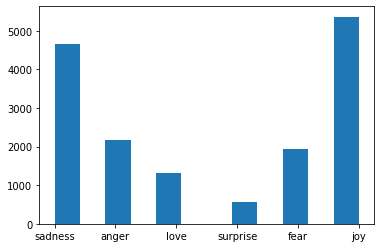

In [49]:
plt.hist(labels, bins=12)
plt.show()

In [52]:
class_to_idx = dict((c, i) for i, c in enumerate(classes))
idx_to_class = dict((v, k) for k, v in class_to_idx.items())

print(class_to_idx)
print(idx_to_class)

{'surprise': 0, 'joy': 1, 'love': 2, 'fear': 3, 'anger': 4, 'sadness': 5}
{0: 'surprise', 1: 'joy', 2: 'love', 3: 'fear', 4: 'anger', 5: 'sadness'}


In [56]:
names_to_ids = lambda labels: np.array([class_to_idx.get(x) for x in labels])

train_labels = names_to_ids(labels)
print(train_labels[0])

5
